# FCIM.M.IA - Artificial Intelligence

> **Lab 5:** Processing Images with OpenCV \\
> **Performed by:** Trifan Denis, group TI-231M \\
> **Verified by:** Mihail Gavrilita, asist. univ.

## Imports and Utils

In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import dlib
import csv

## Task 1 -- Write the following functions using OpenCV. Adjust the parameters and explain your approach. Plot the initial image and the blurred image in the same plot by using Matplotlib subplots. - A blurring function; - A sharpening function;

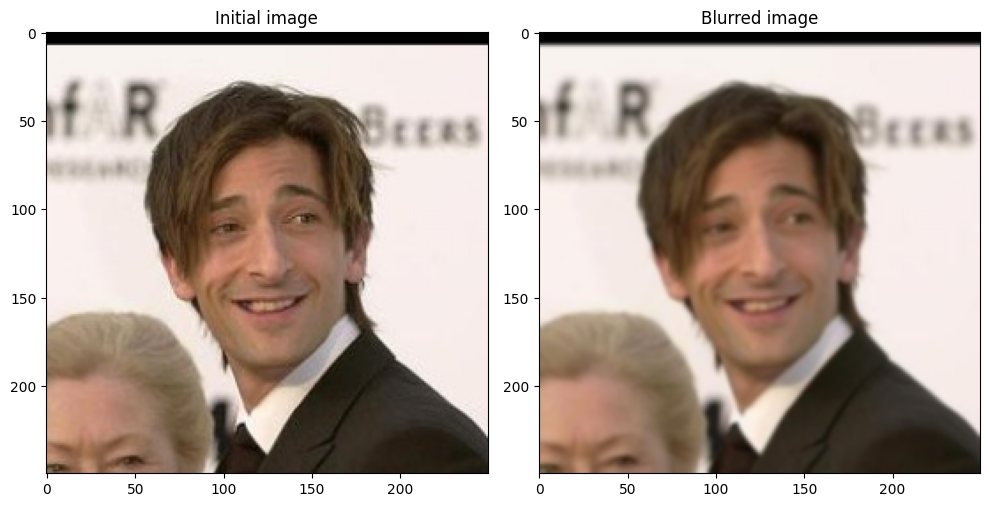

In [2]:
def sharpening_image(image, kernel_size=(5, 5), sigma=1.0, amount=1.5, threshold=0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, threshold)
    return sharpened


def blurring_image(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred


def plot_initial_and_blured_image(img_path):
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blurred_image = blurring_image(image_rgb)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Initial image')
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_image)
    plt.title('Blurred image')
    plt.tight_layout()
    plt.show()
    

image_path = 'test_images/4CA327.jpg'
plot_initial_and_blured_image(image_path)

## Task 2 --  Implement a face detection system using OpenCV. The function should take as input one image and output the result as the coordinates of the face, in case the image contains a  face, or None if the image does not contain any faces. Assume that the image contains no more than one face.

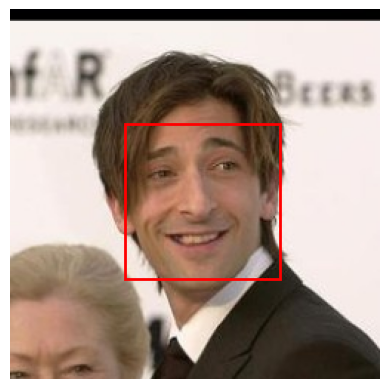

Face detected at coordinates: (77, 77, 105, 105)


In [8]:
def get_face_recognition_coordinates(img_path):
    image = cv2.imread(img_path)
    detector = dlib.get_frontal_face_detector()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray_image)

    if len(faces) == 0:
        print("Photo does not contain faces.")
        return None

    plot_image_and_faces(image, faces)

    face = faces[0]
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    return x, y, w, h


def plot_image_and_faces(image, faces):
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()
    
image_path = 'test_images/4CA327.jpg'
face_coordinates = get_face_recognition_coordinates(image_path)
if face_coordinates is not None:
    print("Face detected at coordinates:", face_coordinates)
else:
    print("No face detected in the image.")

## Task 3 -- Implement a system that detects if a photo is accepted for passport or not, by using OpenCV. You can be creative in determining the optimal strategy, but the system should at least follow the listed requirements. -  The photo should be colored. You can check that by comparing the RGB values of all the pixels. If the image is gray scale image then the values for each pixel should be equal; - The photo should be in portrait orientation or square. Assume that the image given as input is not rotated; - The eyes of a subject should be at the same level (with a max error of 5 pixels); - The photo should contain only one person; - The head of a person should represent 20% to 50% of the area of the photo.

In [7]:
def check_color(image):
    return not (image[:, :, 0] == image[:, :, 1]).all() and not (image[:, :, 0] == image[:, :, 2]).all()


def check_orientation(image):
    height, width, _ = image.shape
    return height >= width


def check_eyes_level(face_landmarks, max_error=10):
    left_eye_y = face_landmarks.part(37).y
    right_eye_y = face_landmarks.part(46).y
    return abs(left_eye_y - right_eye_y) <= max_error


def check_head_size(face_coordinates, image):
    head_area = face_coordinates.area()
    image_area = image.shape[0] * image.shape[1]
    return 0.2 <= head_area / image_area <= 0.5


def passport_acceptance_system(img_path):
    image = cv2.imread(img_path)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray_image)

    if len(faces) != 1:
        return False, "Photo is not accepted for passport. Photo does not contain exactly one person."

    face = faces[0]
    landmarks = predictor(gray_image, face)

    is_check_color = check_color(image)
    if is_check_color:
        is_check_orientation = check_orientation(image)
        if is_check_orientation:
            is_check_eyes_level = check_eyes_level(landmarks)
            if is_check_eyes_level:
                is_check_head_size = check_head_size(face, image)
                if is_check_head_size:
                    return True, "Photo is accepted for passport."
                else:
                    return False, ("Photo is not accepted for passport. The head area is not between 20% and 50% of "
                                   "photo.")
            else:
                return False, "Photo is not accepted for passport. Subject eyes are not on same level (max error 10 px)."
        else:
            return False, "Photo is not accepted for passport. Photo isn't in portrait orientation or square."
    else:
        return False, "Photo is not accepted for passport. Photo isn't colored."
    
image_path = 'test_images/D87D5F.jpg'
is_accepted, message = passport_acceptance_system(image_path)
print("Image is accepted - ", is_accepted, ", reason - ", message)

Image is accepted -  False , reason -  Photo is not accepted for passport. The head area is not between 20% and 50% of photo.


## Task 4 --  Test how good your system performs on a test dataset. You are required to apply your system to all the images in the test set, then compute the accuracy for the solution. - Download the provided image dataset and unzip it in the same folder as this notebook; - Load the dataset from the unzipped folder, in the subfolder test_images. Then read the labels from the file test.csv; - Calculate the accuracy of your system on the test dataset by using the formula : accuracy = nr of images correctly detected / total nr of images

In [11]:
def calculate_accuracy(csv_file):
    total_images = 0
    correctly_detected = 0

    print("Started calculating accuracy...")

    with open(csv_file, newline='') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        for row in csv_reader:
            image_path = row['new_path']
            expected_label = True if row['label'] == 'True' else False

            is_accepted, response = passport_acceptance_system(image_path)

            print("Has been processed image # ", total_images + 1, " response: ", is_accepted, " - reason: ", response)

            total_images += 1
            if is_accepted == expected_label:
                correctly_detected += 1

    print("Finished calculating accuracy.")

    return correctly_detected / total_images if total_images > 0 else 0

csv_file_path = 'test.csv'
accuracy = calculate_accuracy(csv_file_path)
print(f"Accuracy: {accuracy * 100:.2f}%")

Started calculating accuracy...
Has been processed image #  1  response:  False  - reason:  Photo is not accepted for passport. The head area is not between 20% and 50% of photo.
Has been processed image #  2  response:  False  - reason:  Photo is not accepted for passport. The head area is not between 20% and 50% of photo.
Has been processed image #  3  response:  False  - reason:  Photo is not accepted for passport. The head area is not between 20% and 50% of photo.
Has been processed image #  4  response:  False  - reason:  Photo is not accepted for passport. Subject eyes are not on same level (max error 10 px).
Has been processed image #  5  response:  False  - reason:  Photo is not accepted for passport. Subject eyes are not on same level (max error 10 px).
Has been processed image #  6  response:  False  - reason:  Photo is not accepted for passport. The head area is not between 20% and 50% of photo.
Has been processed image #  7  response:  False  - reason:  Photo is not accepte

## Conclusions:

During this work I learned how to use OpenCV for face recognition. Also I created some rules for validating photos that can be applied to different systems.

## Bibliography:

1. Face detection with OpenCV : https://www.datacamp.com/tutorial/face-detection-python-opencv
2. Sharpening image with OpenCV : https://stackoverflow.com/questions/4993082/how-can-i-sharpen-an-image-in-opencv
3. 